# Modeling

To find the best model, firstly we will try to simplify our problem. In this notebook, different modeling techniques can be found. We will use different encoder, scaler , classifier and try different models. For simplfy to find best model, firstly we will merge functional and functional but needs repair target labels, and assign this to target. Then, we will assign non-functional to 0. First, we will try simple model then we will try to improve it. After finding the best model, we will try it for the multi-class label format. 

In [1]:
# importing necessary libraries

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import KBinsDiscretizer, FunctionTransformer,RobustScaler
from sklearn.model_selection import cross_val_score
from category_encoders import OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV

import warnings
warnings.filterwarnings("ignore")

import category_encoders as ce
from category_encoders import WOEEncoder
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder, LeaveOneOutEncoder, JamesSteinEncoder, MEstimateEncoder

from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from mlxtend.plotting import plot_decision_regions
from sklearn.preprocessing import MinMaxScaler
from mlxtend.evaluate import feature_importance_permutation
from sklearn.experimental import enable_hist_gradient_boosting 
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier

from sklearn.svm import SVC

In [2]:
df = pd.read_csv('clean_data.csv') #getting new clean dataframe

In [3]:
pd.options.display.max_columns=100 # to see all columns

In [4]:
# we dropped some columns for now, because we have categorized versions of them
df.drop(columns=['Unnamed: 0','funder','installer','construction_year'],inplace=True )

In [5]:
df1 = df.copy() # to protect original df , take the copy of it

In [6]:
df1.drop(columns=['lga','ward'],inplace=True ) #drop these columns for now

In [7]:
df1['permit'] = df1['permit'].astype(bool).astype(int) #changing from True/False to 0-1

In [8]:
df1['public_meeting'] = df1['public_meeting'].astype(bool).astype(int) #changing from True/False to 0-1

Now, we need to use scaler for numeric columns and encoder for categorical columns. So, we divided columns in two.

In [9]:
cat_col = ['basin','region','extraction_type_group','management','payment','water_quality','quantity',
               'source','waterpoint_type','decade','installer_cat','funder_cat']

In [10]:
num_col = ['gps_height','longitude','latitude','district_code','population','public_meeting','permit']

In [11]:
df1['status_group'].value_counts()

0    32259
2    22824
1     4317
Name: status_group, dtype: int64

0 = functional water points ,

1 = functional but needs repair water points,

2 = non-functinal water points

We collect functional and functional but needs help target together and make them 1, non-functional is 0.

In [12]:
# getting together labels and converting them 
target_status_group = {0:1, 1: 1, 2 : 0}
df1['status_group'] = df1['status_group'].replace(target_status_group)

In [13]:
df1['status_group'].value_counts()

1    36576
0    22824
Name: status_group, dtype: int64

Now, 1 shows functional,

0 shows non-functional after here.

In [14]:
target='status_group' #assign out target column as target

# Making Pipeline / Baseline

In [37]:
# Dividing X and target 

used_cols = [c for c in df1.columns.tolist() if c not in [target]]
X=df1[used_cols]
y=df1[target]

In [38]:
# to divide our X and y to test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In this notebook, we will use train test split firstly to figure out the problem. After learning from the baseline, we will use cross validation technique to find the best result. Because, it is more convenient and easy to understand how is going on. For some models, we will use both of them to check our results are consistant or not. 
The metric for competition is balanced accuracy. But, to make sure and understand the progress, we want to check roc_auc score also especially for some models.

We will create empty dataframe to write our results on it to keep when parameters changed.

In [17]:
df_results = pd.DataFrame(columns=["Model", "Scaler",'Encoder',
                                   'roc_auc score mean', 'roc_auc score std']) # to see all results

## Baseline - Robust Scaler/ Target Encoder with LogReg

To scale numeric values and encode categorical columns, we will make pipeline and also use it in our model and classifier changes. For the first trial we use Robust Scaler as a scaler. Robust scales variables using statistics that are strong to outliers. Robust Scaler use IQR(Interquartile Range). As a encoder, we will try target encoder which works well with higher cardinality features. Our data has higher unique values also. 
Our first trial for baseline is Logistic Regression which predicts the probability that a certain instance belongs to a class. We chose balanced as class weight, because our classes have imbalanced. And also, solver is an algorithm to use in the optimization problem and for multiclass problems ‘lbfgs’ can handle multinomial loss. 

In [39]:
#making pipeline

scaler = RobustScaler()
encoder = ce.TargetEncoder(cols=cat_col)

# putting numeric columns to scaler and categorical to encoder
num_transformer = make_pipeline(scaler)
cat_transformer = make_pipeline(encoder)

# getting together our scaler and encoder with preprocessor
preprocessor = ColumnTransformer(
      transformers=[('num', num_transformer, num_col),
                    ('cat', cat_transformer, cat_col)])


# choosing model
lr = LogisticRegression(class_weight = 'balanced', solver = 'lbfgs', random_state=42)

# giving all values to pipeline
pipe = make_pipeline(preprocessor,lr)
pipe.fit(X_train, y_train)


# make predictions on training set
y_pred = pipe.predict(X_train)

# make predictions on test set
y_score = pipe.predict(X_test)

# to print the results in good way
print("Accuracy:"); print("="*len("Accuracy:"))
print(f"TRAIN: {accuracy_score(y_train, y_pred)}")
print(f"TEST: {accuracy_score(y_test, y_score)}")

print("\nBalanced Accuracy:"); print("="*len("Balanced Accuracy:"))
print(f"TRAIN: {balanced_accuracy_score(y_train, y_pred)}")
print(f"TEST: {balanced_accuracy_score(y_test, y_score)}")


Accuracy:
TRAIN: 0.7718855218855218
TEST: 0.7742424242424243

Balanced Accuracy:
TRAIN: 0.7514242992528544
TEST: 0.7529177387309345


For the first trial, this values can be chosen as baseline. We have already fine acceptable results for baseline. There is overfit but not much. For better understanding, we will plot confusion matrix.

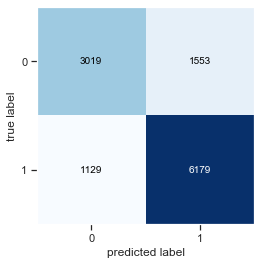

In [19]:
# to plot and understand confusion matrix
cm = confusion_matrix(y_test, y_score)
plot_confusion_matrix(cm)
plt.show()

From the above matrix, we can make some interpretations. Such that, 1129 represents we predicted as non-functional but normally they are functional. And, 1553 shows that we predicted as functional, but normally they are non-functional.

Now, we will take the roc_auc score with doing LogReg with cross validation to compare other model results. We will take the mean of the scores, and standard deviation to understand better. We choose cv as 5, it gives 5 different results for each trial. We get and use mean of them. This application will give us more accurate results. Instead of train-test splits, we prefer cross validation which splitting train-test itself and do it for 5 times. It takes more time then train-test split so in some models, we will prefer train-test split again.

In [20]:
scores = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std()) 

0.8313663919758361 +/- 0.0040017382683380015


We find better results than splitting even. And this result is better enough for baseline. Std is not too high also. These all results show us the importance of data cleaning. We tried to clean our data well. Maybe because of good cleaning we get good results for simple model.

In [22]:
df_results = df_results.append({       # first trial is written in results 
     "Model": 'LogReg' ,
      "Scaler": 'Robust' , 
       'Encoder' : 'TargetEncoder',
               'roc_auc score mean' : 0.8313,
                    'roc_auc score std' : 0.0041}, ignore_index=True)


#  Robust Scaler/ WoE Encoder with LogReg

The weight of evidence encoder works as the predictive power of an independent variable accorfing to the dependent variable. It means that bad vs good. Basically, it is calculating the % of events and % of non-events. 

In [40]:
scaler = RobustScaler()
encoder = ce.WOEEncoder(cols=cat_col)

# putting numeric columns to scaler and categorical to encoder
num_transformer = make_pipeline(scaler)
cat_transformer = make_pipeline(encoder)

# getting together our scaler and encoder with preprocessor
preprocessor = ColumnTransformer(
      transformers=[('num', num_transformer, num_col),
                    ('cat', cat_transformer, cat_col)])

# giving all values to pipeline
pipe = make_pipeline(preprocessor,lr)

scores = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std()) 


0.8317616620004907 +/- 0.0040460161388364115


It makes better than baseline. So, we will change our encoder to this one. 

In [23]:
df_results = df_results.append({       # results written in dataframe
     "Model": 'LogReg' ,
      "Scaler": 'Robust' , 
       'Encoder' : 'WeO',
                'roc_auc score mean' : 0.8318,
                    'roc_auc score std' : 0.0040}, ignore_index=True)


# Robust Scaler/ LeaveOneOut Encoder with LogReg

In [39]:
scaler = RobustScaler()
encoder = ce.LeaveOneOutEncoder(cols=cat_col)

num_transformer = make_pipeline(scaler)
cat_transformer = make_pipeline(encoder)


preprocessor = ColumnTransformer(
      transformers=[('num', num_transformer, num_col),
                    ('cat', cat_transformer, cat_col)])

pipe = make_pipeline(preprocessor,lr)

scores = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std())



0.8312797087089017 +/- 0.004066043448636809


It did not better than WoE encoder. So, we will not change it. 

In [25]:
df_results = df_results.append({       # results written in dataframe
     "Model": 'LogReg' ,
      "Scaler": 'Robust' , 
       'Encoder' : 'LeaveOneOut',
                'roc_auc score mean' : 0.8313,
                    'roc_auc score std' : 0.0041}, ignore_index=True)


# Robust Scaler/ OneHot Encoder with LogReg

In [41]:
scaler = RobustScaler()
encoder = ce.OneHotEncoder(cols=cat_col)

num_transformer = make_pipeline(scaler)
cat_transformer = make_pipeline(encoder)


preprocessor = ColumnTransformer(
      transformers=[('num', num_transformer, num_col),
                    ('cat', cat_transformer, cat_col)])

pipe = make_pipeline(preprocessor,lr)

scores = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std())

pipe.fit(X_train, y_train)

# make predictions on training set
y_pred = pipe.predict(X_train)

# make predictions on test set
y_score = pipe.predict(X_test)

# to print the results in good way
print("Accuracy:"); print("="*len("Accuracy:"))
print(f"TRAIN: {accuracy_score(y_train, y_pred)}")
print(f"TEST: {accuracy_score(y_test, y_score)}")

print("\nBalanced Accuracy:"); print("="*len("Balanced Accuracy:"))
print(f"TRAIN: {balanced_accuracy_score(y_train, y_pred)}")
print(f"TEST: {balanced_accuracy_score(y_test, y_score)}")


0.8538287641042815 +/- 0.0024018659896273917
Accuracy:
TRAIN: 0.7922348484848485
TEST: 0.790993265993266

Balanced Accuracy:
TRAIN: 0.7773474554272171
TEST: 0.7753766770532994


Although one-hot encoder gives the best value, we choose our encoder as weight of evidence encoder. Because one-hot encoder creates a binary feature for each unique value in column. So, it is not very useful for high cardinality categorical values like our data. Because, it takes too much time to run the model each time. 

In [26]:
df_results = df_results.append({       # results written in dataframe
     "Model": 'LogReg' ,
      "Scaler": 'Robust' , 
       'Encoder' : 'OneHot',
                'roc_auc score mean' : 0.8538,
                    'roc_auc score std' : 0.0024}, ignore_index=True)


# MinMax Scaler/ WoE Encoder with LogReg

In [46]:
scaler = MinMaxScaler()
encoder = ce.WOEEncoder(cols=cat_col)

# putting numeric columns to scaler and categorical to encoder
num_transformer = make_pipeline(scaler)
cat_transformer = make_pipeline(encoder)

# getting together our scaler and encoder with preprocessor
preprocessor = ColumnTransformer(
      transformers=[('num', num_transformer, num_col),
                    ('cat', cat_transformer, cat_col)])

# giving all values to pipeline
pipe = make_pipeline(preprocessor,lr)

scores = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std()) 

0.831729064936378 +/- 0.0040065625540644


The result does not change significantly so, we decided our encoder as WoE and scaler as Robust.

In [27]:
df_results = df_results.append({       # results written in dataframe
     "Model": 'LogReg' ,
      "Scaler": 'MinMax' , 
       'Encoder' : 'OneHot',
                'roc_auc score mean' : 0.8317,
                    'roc_auc score std' : 0.0040}, ignore_index=True)


# Comparing Different Encoder and Scalers

In [28]:
df_results

,Model,Scaler,Encoder,roc_auc score mean,roc_auc score std
0,LogReg,Robust,TargetEncoder,0.8313,0.0041
1,LogReg,Robust,WeO,0.8318,0.0040
2,LogReg,Robust,LeaveOneOut,0.8313,0.0041
3,LogReg,Robust,OneHot,0.8538,0.0024
4,LogReg,MinMax,OneHot,0.8317,0.0040


For updated baseline, we choose WeO encoder with Robust scaler. Although, one hot encoder gave better results, it is not very suitable for our dataset which contains high unique numbers in columns.

# Decision Tree Classifier

In [57]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_leaf=5, 
                            random_state=42, class_weight='balanced')

pipe = make_pipeline(preprocessor,dt)

scores = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std())

0.786350564101643 +/- 0.008901914029896015


In [28]:
df_results = df_results.append({       # results written in dataframe
     "Model": 'DecisionTreeClassifier' ,
      "Scaler": 'Robust' , 
       'Encoder' : 'WoE',
                'roc_auc score mean' : 0.7864,
                    'roc_auc score std' : 0.0089}, ignore_index=True)

# EkstraTreesClassifier

In [59]:
rf_ext = ExtraTreesClassifier(max_depth=5, criterion= 'gini', min_samples_leaf=3, min_samples_split=18, 
                          random_state=42, n_estimators = 57, class_weight='balanced', n_jobs = -1)

pipe = make_pipeline(preprocessor,rf_ext)

scores = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std())

0.8330045498519901 +/- 0.004055072674209609


In [29]:
df_results = df_results.append({       # results written in dataframe
     "Model": 'ExtraTreesClassifier' ,
      "Scaler": 'Robust' , 
       'Encoder' : 'WoE',
                'roc_auc score mean' : 0.8330,
                    'roc_auc score std' : 0.0041}, ignore_index=True)

# RandomForestClassifier

In [61]:
rf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1,class_weight='balanced')

pipe = make_pipeline(preprocessor,rf)

scores = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std())

0.919346222336363 +/- 0.0022277007468852186


In [30]:
df_results = df_results.append({       # results written in dataframe
     "Model": 'RandomForestClassifier' ,
      "Scaler": 'Robust' , 
       'Encoder' : 'WoE',
                'roc_auc score mean' : 0.9193,
                    'roc_auc score std' : 0.0022}, ignore_index=True)

In [31]:
df2=df1.copy()

In [32]:
encoder = WOEEncoder()

for c in cat_col:
    df2[str(c) + '_encoded'] = encoder.fit_transform(df2[c].values, df2[target])
    df2.drop(columns=c, inplace=True) 

In [33]:
used_cols1 = [c for c in df2.columns.tolist() if c not in [target]]
X1=df2[used_cols1]
y1=df2[target]

X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

In [95]:
grid_p = {"n_estimators": [20, 50, 100],
          "criterion": ["gini", "entropy"],
          "max_features": ['sqrt', 'log2']}

grid_search = GridSearchCV(rf, grid_p, n_jobs=-1, cv=5, scoring='roc_auc')

grid_search.fit(X_train, y_train)

# clf = make_pipeline(preprocessor, 
#                     GridSearchCV(rf, grid_p,n_jobs=-1, cv=5, scoring='roc_auc',refit=True))

# clf.fit(X_train, y_train)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=50, n_jobs=-1,
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_start=False),
             iid='

In [96]:
grid_search.best_score_

0.9192432433420936

In [97]:
grid_search.best_params_

{'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 100}

In [99]:
grid_p = {"n_estimators": [20, 50, 100],
          "criterion": ["gini", "entropy"],
          "max_features": ['sqrt', 'log2'],
          "min_samples_split": [2, 5, 10]}

grid_search = GridSearchCV(rf, grid_p, n_jobs=-1, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=50, n_jobs=-1,
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_start=False),
             iid='

In [100]:
grid_search.best_score_

0.9218773133232117

In [101]:
grid_search.best_params_

{'criterion': 'entropy',
 'max_features': 'sqrt',
 'min_samples_split': 10,
 'n_estimators': 100}

In [102]:
best_rf = grid_search.best_estimator_

In [103]:
scores = cross_val_score(best_rf, X1, y1, cv=5, scoring='roc_auc') 
print(scores.mean(), "+/-", scores.std())


0.9243196643217907 +/- 0.0023412211439206173


In [31]:
df_results = df_results.append({       # results written in dataframe
     "Model": 'RandomForestClassifier' ,
      "Scaler": 'Robust' , 
       'Encoder' : 'WoE',
                'roc_auc score mean' : 0.9243,
                    'roc_auc score std' : 0.0023}, ignore_index=True)

In [107]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=50, n_jobs=-1, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

Feature ranking:
1. feature 13 (0.147108)
2. feature 1 (0.143442)
3. feature 2 (0.141844)
4. feature 0 (0.072635)
5. feature 9 (0.068399)
6. feature 15 (0.062552)
7. feature 11 (0.050384)
8. feature 4 (0.050012)
9. feature 16 (0.034497)
10. feature 14 (0.033488)
11. feature 8 (0.032305)
12. feature 17 (0.031510)
13. feature 18 (0.030117)
14. feature 3 (0.026134)
15. feature 10 (0.025112)
16. feature 7 (0.018418)
17. feature 12 (0.015914)
18. feature 6 (0.009392)
19. feature 5 (0.006736)


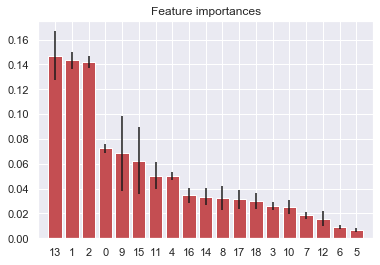

In [109]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X1.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X1.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X1.shape[1]), indices)
plt.xlim([-1, X1.shape[1]])
plt.show()

In [115]:
discard = ['public_meeting', 'permit']
used_cols2 = [c for c in df2.columns.tolist() if c not in [target] + discard]
X2, y2 = df2[used_cols2], df2[target]

X2.head()

,gps_height,longitude,latitude,district_code,population,basin_encoded,region_encoded,extraction_type_group_encoded,management_encoded,payment_encoded,water_quality_encoded,quantity_encoded,source_encoded,waterpoint_type_encoded,decade_encoded,installer_cat_encoded,funder_cat_encoded
0,1390,34.938093,-9.856322,5,109,0.388985,0.948366,0.376213,-0.176906,1.044652,0.115811,0.495996,0.362610,0.379126,-0.038879,0.130852,0.197146
1,1399,34.698766,-2.147466,2,280,-0.090414,-0.549719,0.376213,0.368528,-0.374904,0.115811,0.014014,0.577184,0.379126,0.780469,0.130852,0.197146
2,686,37.460664,-3.821329,4,250,0.166077,0.300260,0.376213,-0.176906,0.489178,0.115811,0.495996,-0.784097,-0.582060,0.449726,0.617328,0.197146
3,263,38.486161,-11.155298,63,58,-0.695391,-0.978679,-0.150088,-0.176906,-0.374904,0.115811,-3.906856,-0.335742,-0.582060,-0.576302,0.130852,0.196211
4,0,31.130847,-1.825359,1,281,-0.090414,-0.014063,0.376213,0.205685,-0.374904,0.115811,0.267114,0.577184,0.379126,-0.082471,0.130852,0.197146


In [116]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1,class_weight='balanced',
                        criterion ='entropy',max_features = 'sqrt', min_samples_split = 10)

scores = cross_val_score(rf, X2, y2, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std())

0.9241922995399895 +/- 0.0019821293437990617


In [33]:
df_results = df_results.append({       # results written in dataframe
     "Model": 'RFClassifier w/feature selection' ,
      "Scaler": 'Robust' , 
       'Encoder' : 'WoE',
                'roc_auc score mean' : 0.9242,
                    'roc_auc score std' : 0.0020}, ignore_index=True)

In [124]:
num_col = ['gps_height','longitude','latitude','district_code','population','public_meeting','permit']

In [125]:
X1.drop(columns=num_col,inplace=True ) 

In [128]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=10, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

Feature ranking:
1. feature 6 (0.223393)
2. feature 2 (0.108580)
3. feature 8 (0.089631)
4. feature 1 (0.081797)
5. feature 4 (0.079386)
6. feature 9 (0.073318)
7. feature 10 (0.068772)
8. feature 11 (0.065870)
9. feature 7 (0.064373)
10. feature 0 (0.058981)
11. feature 3 (0.054432)
12. feature 5 (0.031466)


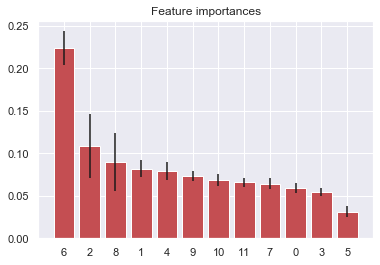

In [129]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X1.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X1.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X1.shape[1]), indices)
plt.xlim([-1, X1.shape[1]])
plt.show()

# XGBC Classifier

In [ ]:
# https://xgboost.readthedocs.io/en/latest/build.html

In [22]:
import xgboost as xgb

In [23]:
from xgboost import XGBClassifier

Accuracy:
TRAIN: 0.9379419191919192
TEST: 0.8624579124579125

Balanced Accuracy:
TRAIN: 0.9236170246317847
TEST: 0.8395642355050446


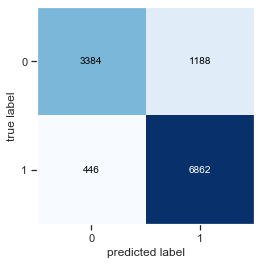

In [41]:
# choosing model
xgb = XGBClassifier(objective = 'multi:softmax', booster = 'gbtree', nrounds = 'min.error.idx',
                      num_class = 3, maximize = False, eval_metric = 'merror', eta = .1,
                      max_depth = 12, colsample_bytree = .4, learning_rate = 0.1)

pipe = make_pipeline(preprocessor,xgb)
pipe.fit(X_train, y_train)


# make predictions on training set
y_pred = pipe.predict(X_train)

# make predictions on test set
y_score = pipe.predict(X_test)

# to print the results in good way
print("Accuracy:"); print("="*len("Accuracy:"))
print(f"TRAIN: {accuracy_score(y_train, y_pred)}")
print(f"TEST: {accuracy_score(y_test, y_score)}")

print("\nBalanced Accuracy:"); print("="*len("Balanced Accuracy:"))
print(f"TRAIN: {balanced_accuracy_score(y_train, y_pred)}")
print(f"TEST: {balanced_accuracy_score(y_test, y_score)}")


cm = confusion_matrix(y_test, y_score)
plot_confusion_matrix(cm)
plt.show()

In [ ]:
XGBClassifier()

In [30]:
xgb = XGBClassifier(objective = 'multi:softmax', booster = 'gbtree', nrounds = 'min.error.idx',
                      num_class = 3, maximize = False, eval_metric = 'merror', eta = .1,
                      max_depth = 12, colsample_bytree = .4, learning_rate = 0.1)

pipe = make_pipeline(preprocessor,xgb)
scores = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std())

0.8403013310952565 +/- 0.003629546531984922


# k-Nearest Neighbors

In [46]:
from sklearn.neighbors import KNeighborsClassifier

In [48]:
knn = KNeighborsClassifier()

pipe = make_pipeline(preprocessor,knn)
scores = cross_val_score(pipe, X, y, cv=5, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std())

0.8852624439664136 +/- 0.0023672331839737193


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, 
                                                    stratify=y.values, random_state=42)
pipe.fit(X_train, y_train)


imp_vals, _ = feature_importance_permutation(
    predict_method=knn.predict, 
    X=X_test,
    y=y_test,
    metric='accuracy',
    num_rounds=1,
    seed=1)

indices = np.argsort(imp_vals)[::-1]
plt.figure()
plt.title("k-NN feature importance via permutation importance")
plt.bar(range(X.shape[1]), imp_vals[indices])
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.ylim([0, 0.5])
plt.show()

# LGBM Classifier

In [24]:
import gc; gc.enable()

In [42]:
import lightgbm as lgb

In [43]:

from lightgbm import LGBMClassifier

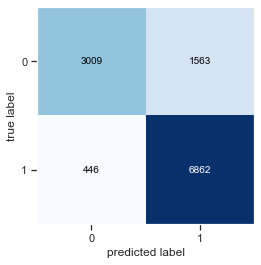

In [44]:
#light gbm
lgm = LGBMClassifier(booster = 'gbtree', nrounds = 'min.error.idx', maximize = False, eval_metric = 'merror',
                     eta = .1,max_depth = 14, colsample_bytree = .4)

#fit
pipe = make_pipeline(preprocessor,lgm)
pipe.fit(X_train, y_train)

# make predictions on training set
y_pred = pipe.predict(X_train)

# make predictions on hold-out set
y_score = pipe.predict(X_test)

#confusion matrix
cm = confusion_matrix(y_test, y_score)
plot_confusion_matrix(cm)
plt.show()

In [45]:
print("Accuracy:"); print("="*len("Accuracy:"))
print(f"TRAIN: {accuracy_score(y_train, y_pred)}")
print(f"TEST: {accuracy_score(y_test, y_score)}")

print("\nBalanced Accuracy:"); print("="*len("Balanced Accuracy:"))
print(f"TRAIN: {balanced_accuracy_score(y_train, y_pred)}")
print(f"TEST: {balanced_accuracy_score(y_test, y_score)}")


Accuracy:
TRAIN: 0.8424031986531987
TEST: 0.8308922558922559

Balanced Accuracy:
TRAIN: 0.811279742481843
TEST: 0.7985537368173805
